<a href="https://colab.research.google.com/github/divyanshbajpai/EVA4-Coursework/blob/master/Assignment-4/MNIST_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Packages**

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as Function
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms
from __future__ import print_function

**Define the NN Model**


In [0]:
#Using batch norm and dropout
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, bias = False), #26
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.15),
            
            nn.Conv2d(16, 16, 3, bias = False),#24
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.15),

            nn.Conv2d(16, 32, 3, bias = False),#22
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.15),
            
            nn.MaxPool2d(2, 2)#11
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,8,1,bias=False),#11
            
            nn.Conv2d(8, 16, 3, bias = False),#9
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.15),

            nn.Conv2d(16, 16, 3, bias = False),#7
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.15),
            
            nn.Conv2d(16, 16, 3, bias = False, padding=1),#7
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.15),
            
            nn.Conv2d(16, 32, 3, bias = False),#5
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(32,10,1)
            #nn.AvgPool2d(1)
        )
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # x = self.conv3(x)
        
        # x = x.view(x.size(0), -1)
        # x = self.fc(x)
        x = x.view(-1, 10)
        x = Function.log_softmax(x, dim=1)
        return x

**Visualize the model**

In [3]:
!pip install torchsummary

from torchsummary import summary 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Model().to(device)
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 32, 22, 22]           4,608
             ReLU-10           [-1, 32, 22, 22]               0
      BatchNorm2d-11           [-1, 32, 22, 22]              64
          Dropout-12           [-1, 32, 22, 22]               0
        MaxPool2d-13           [-1, 32, 11, 11]               0
           Conv2d-14            [-1, 8,

In [0]:

torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    running_loss=0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        #loss = criterion(output, target)
        loss = Function.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss
        # pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += Function.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (correct / len(test_loader.dataset))

In [7]:

model = Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epoch_loss = []
test_acc = []
for epoch in range(1, 20):
    rl=train(model, device, train_loader, optimizer, epoch)
    teacc=test(model, device, test_loader)
    epoch_loss.append(rl/batch_size)
    test_acc.append(teacc)

  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0589, Accuracy: 9817/10000 (98.17%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9888/10000 (98.88%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9920/10000 (99.20%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9915/10000 (99.15%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9920/10000 (99.20%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9921/10000 (99.21%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9926/10000 (99.26%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9926/10000 (99.26%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9920/10000 (99.20%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9926/10000 (99.26%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9936/10000 (99.36%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9932/10000 (99.32%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9937/10000 (99.37%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9953/10000 (99.53%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9936/10000 (99.36%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9941/10000 (99.41%)



100%|██████████| 938/938 [00:12<00:00, 74.50it/s]



Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)



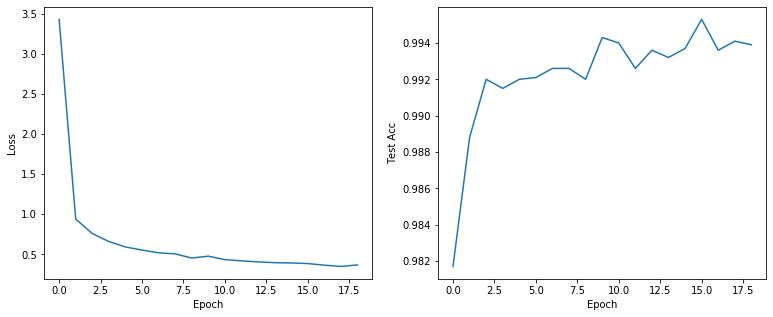

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('loss.png')
plt.subplot(132)
plt.plot(test_acc)
plt.xlabel('Epoch')
plt.ylabel('Test Acc')
plt.savefig('loss.png')
plt.show()